In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from math import sqrt


In [66]:
links = []
list_html = []
list_html0 = []
carname = []
listing_data = []
prices = []


for page in range(1,10,1):
    url = f'https://www.autouncle.dk/da/brugte-biler/f-benzin?page={page}&search_form=1'
    links.append(url)
    
for url in links:
    response = requests.get(url, headers={'email':'ptj867@alumni.ku.dk', 'Purpose':'For exam project'})
    time.sleep(2)
    list_html.append(response)

for url0 in list_html:
    soup = BeautifulSoup(url0.content, 'lxml')
    list_html0.append(soup)
    
for element in list_html0:
    inner_rows = element.find_all('a', class_='listing-item-headline truncated')
    carname.append(inner_rows)

flat_list = [item for sublist in carname for item in sublist]
carname_df = pd.DataFrame(flat_list)


for data in list_html0:
    inner_rows1 = data.find_all('div', class_='listing-item-info-chip')
    listing_data+=inner_rows1

Year = [
    [div_element for div_element in inner_list if re.search(r"\d{4}", div_element.get_text())]
    for inner_list in listing_data
]

KM = [
    [div_element for div_element in inner_list if "km" in div_element.get_text()]
    for inner_list in listing_data
]
Motor = [
    [div_element for div_element in inner_list if "Benzin" in div_element.get_text()]
    for inner_list in listing_data
]
Gear = [
    [div_element for div_element in inner_list if "gear" in div_element.get_text()]
    for inner_list in listing_data
]
HK = [
    [div_element for div_element in inner_list if "HK" in div_element.get_text()]
    for inner_list in listing_data
]
df = pd.DataFrame({'Year':Year,'KM':KM, 'Motor':Motor, 'Gear':Gear, 'HK':HK})
df = df[df.applymap(lambda x: x != []).any(axis=1)]
df['Year'] = df['Year'].shift(4)
df['KM'] = df['KM'].shift(3)
df['Motor'] = df['Motor'].shift(2)
df['Gear'] = df['Gear'].shift(1)
df = df.applymap(lambda x: [] if 'CO2' in str(x) else x)
df = df.applymap(lambda x: [] if x is None else x)
df = df[df.applymap(lambda x: x != []).any(axis=1)]
df.reset_index(inplace=True)


for price in list_html0:    
    inner_rows2 = price.find_all('div', class_='listing-item-price')
    prices+= inner_rows2  # Append the text, not the element itself
pricesdf = pd.DataFrame({'Price': prices})
pricesdf

def extract_numeric_value(cell):
    match = re.search(r'\d+\.\d+', cell)
    if match:
        return match.group()
    else:
        return None

cleaned_prices = pricesdf.applymap(lambda cell: extract_numeric_value(str(cell)))

final_data = pd.concat([carname_df, cleaned_prices, df], axis=1)
final_data = final_data.drop(columns=['index'])

columns = ['Title','Price (DKK)', 'Year', 'KM driven', 'Motor (Litres)', 'Transmission', 'Horsepower']
final_data.columns=columns


In [67]:
#Removing brackets and quotations marks from all cells
for col in columns:
    final_data[col] = final_data[col].astype(str).str.replace(r'\[|\]','', regex=True).str.replace(r'\'|\'','', regex=True)

#Cleaning up the dataset, converting integers, strings etc.  
final_data['KM driven'] = final_data['KM driven'].str.replace(' km', '').str.replace('.', '').astype(int)
final_data['Motor (Litres)'] = final_data['Motor (Litres)'].str.replace('L Benzin', '').astype(float)
final_data['Price (DKK)']= final_data['Price (DKK)'].str.replace('.', '').astype(int)

#Cleansing the Horsepower column for letters, such it can be converted to an interger
final_data['Horsepower'] = final_data['Horsepower'].str.replace(r'\(.*\)', '', regex=True).str.replace(r'\D', '', regex=True).str.strip()
final_data = final_data[final_data['Horsepower'] != '']
final_data['Horsepower'] = final_data['Horsepower'].astype(int)

#Removing months from the year column
final_data['Year'] = final_data['Year'].str.replace(r'\D', '', regex=True).astype(int)

#Creating new 'Car Manufacturer' column by extracting the first word of the 'Title'column.
final_data['Car Manufacturer'] = final_data['Title'].str.split().str[0].astype(str)



#Cleaning the 'Title' column
final_data['Title'] = final_data['Title'].str.rstrip('aut. \n')

#Import Car Manufacturer Specs and merge it with 'final_data' in order to include the 'country of origin'-column
car_manufacturer_specs = pd.read_csv('Car Manufacturer Specification.csv', sep=';')
final_data = pd.merge(final_data, car_manufacturer_specs, on='Car Manufacturer')


final_data

/var/folders/x2/pd2_0wnx52bb474g018r9ns00000gn/T/ipykernel_32741/664719555.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_data['KM driven'] = final_data['KM driven'].str.replace(' km', '').str.replace('.', '').astype(int)
/var/folders/x2/pd2_0wnx52bb474g018r9ns00000gn/T/ipykernel_32741/664719555.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_data['Price (DKK)']= final_data['Price (DKK)'].str.replace('.', '').astype(int)


,Title,Price (DKK),Year,KM driven,Motor (Litres),Transmission,Horsepower,Car Manufacturer,Country of Origin
0,"Mercedes GLA200 1,3 Advantage",479900,2022,14000,1.3,Manuelt gear,163,Mercedes,Germany
1,"Mercedes C300 2,0 AMG Line",589900,2022,14000,2.0,Manuelt gear,258,Mercedes,Germany
2,"Mercedes A200 1,3 Advantage AMG",389900,2023,12000,1.3,Automatgear,163,Mercedes,Germany
3,"Mercedes A200 1,3 AMG Line",344900,2020,39000,1.3,Automatgear,163,Mercedes,Germany
4,"Mercedes GLA200 1,3 Advantage",469900,2022,21000,1.3,Automatgear,163,Mercedes,Germany
...,...,...,...,...,...,...,...,...,...
208,"Peugeot 308 1,2 PureTech Style 130HK 5d 6g",184900,2020,29500,1.2,Manuelt gear,130,Peugeot,France
209,"Peugeot 2008 1,2 PureTech 130 Allure Tour",219900,2020,36000,1.2,Manuelt gear,130,Peugeot,France
210,"Peugeot 208 1,2 VTi 82 Strike",109900,2018,33000,1.2,Manuelt gear,82,Peugeot,France
211,"Hyundai i30 199.900 kr. Cw 1,4 T-GDI Premium D...",199900,2019,101000,1.4,Automatgear,140,Hyundai,South Korea


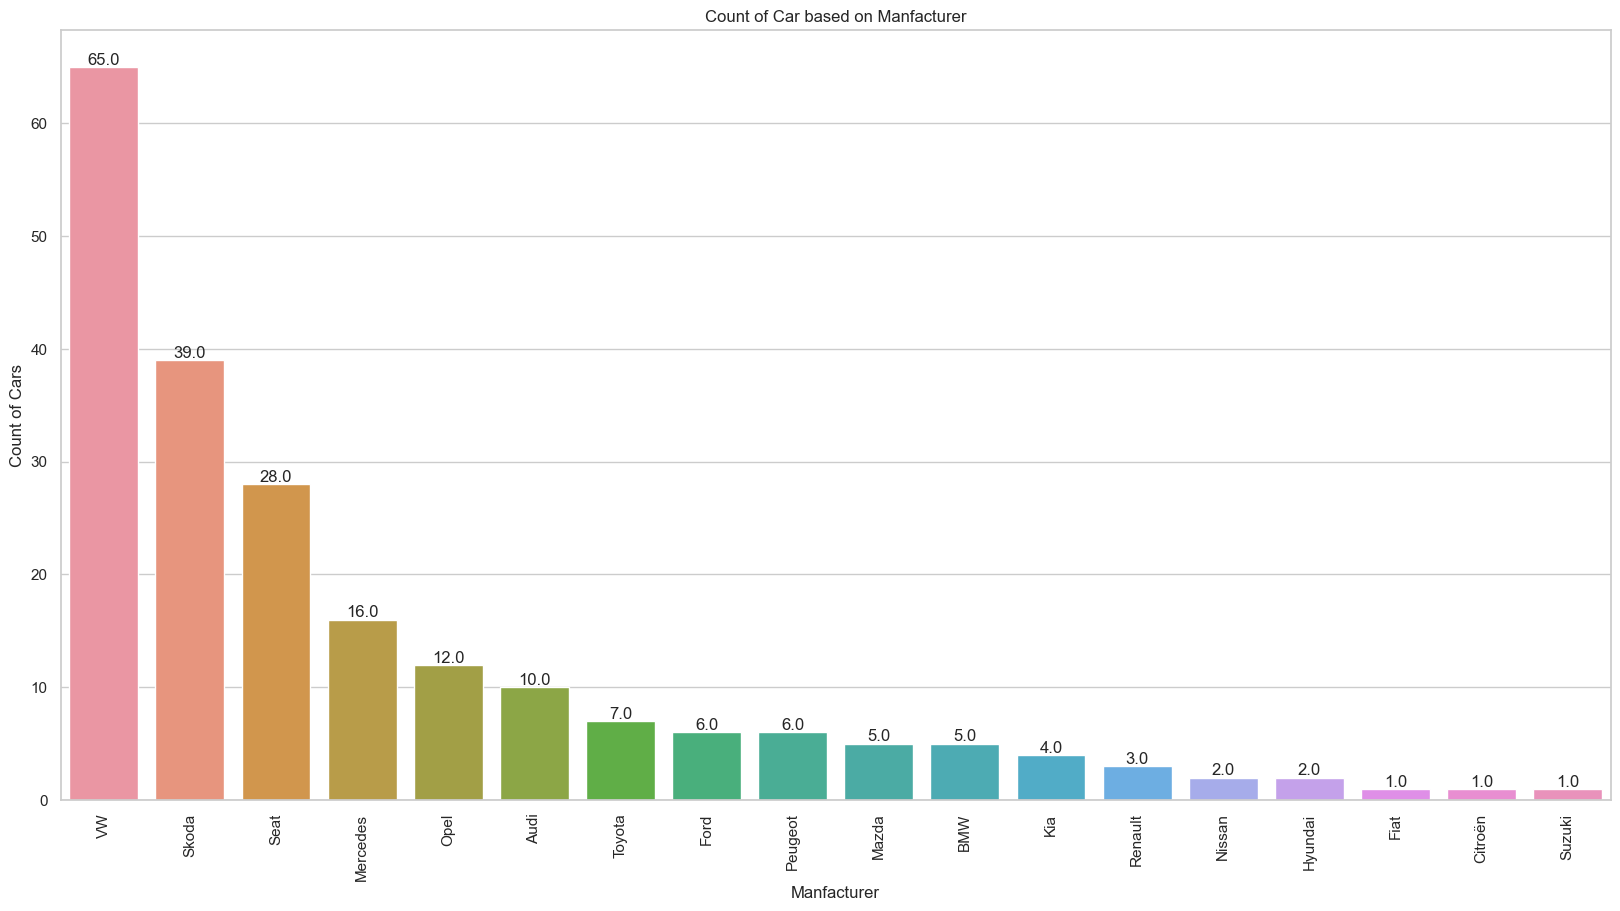

In [68]:
plt.rcParams['figure.figsize'] = 20,10
Cars = final_data['Car Manufacturer'].value_counts()
plot = sns.barplot(x = Cars.index,y = Cars.values,data = df)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Car based on Manfacturer')
plt.xlabel('Manfacturer')
plt.ylabel('Count of Cars')
plt.savefig('Count of Cars.png')
plt.show()

/var/folders/x2/pd2_0wnx52bb474g018r9ns00000gn/T/ipykernel_32741/1318318993.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(final_data.corr(),cmap = sns.cubehelix_palette(as_cmap = True),annot = True, cbar = True,square = True)


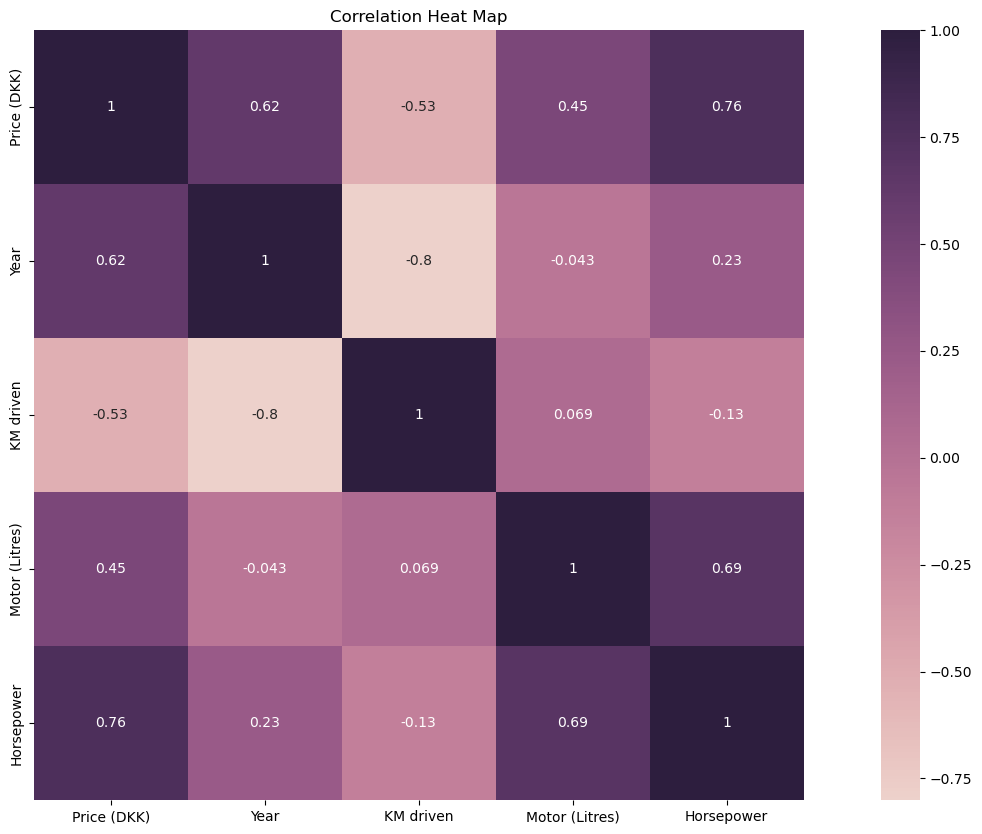

In [39]:
sns.heatmap(final_data.corr(),cmap = sns.cubehelix_palette(as_cmap = True),annot = True, cbar = True,square = True)
plt.title('Correlation Heat Map')
plt.savefig('Correlation Heat Map.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


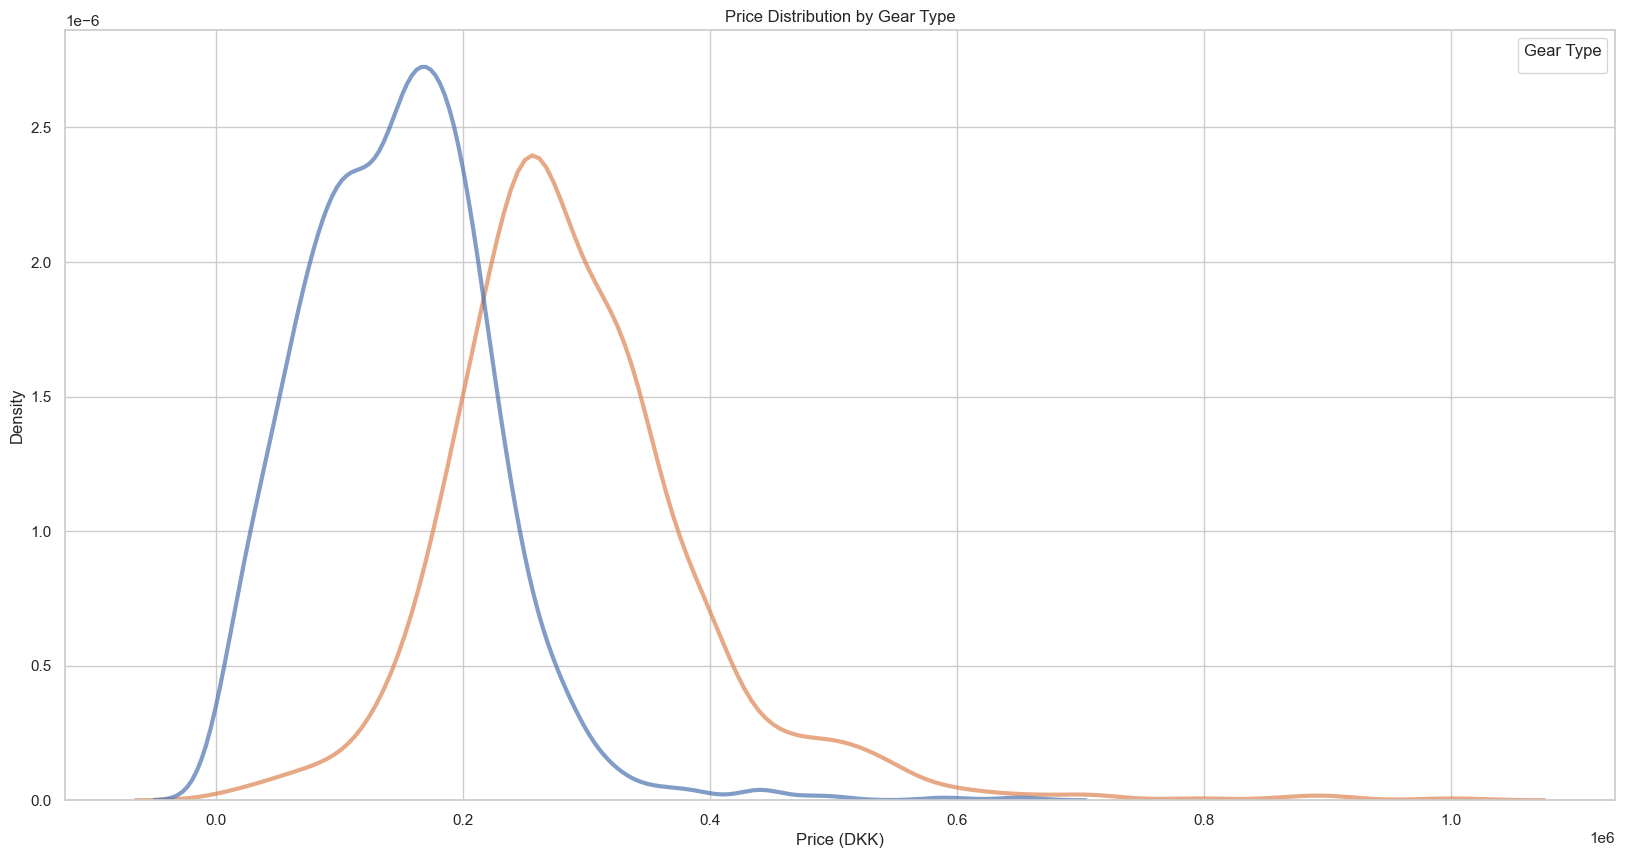

In [62]:
sns.kdeplot(data=final_data, x="Price (DKK)", hue="Manual/Automatic gear", multiple="layer", linewidth=3, alpha=0.7)
plt.title("Price Distribution by Gear Type")
plt.xlabel("Price (DKK)")
plt.ylabel("Density")

# Add legend
plt.legend(title="Gear Type")

# Show the plot
plt.show()


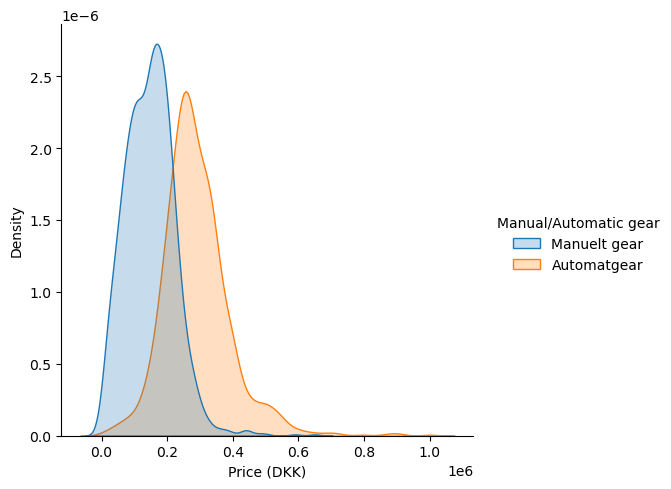

In [7]:
sns.displot(data=final_data, x="Price (DKK)", hue="Manual/Automatic gear", kind="kde", fill=True)


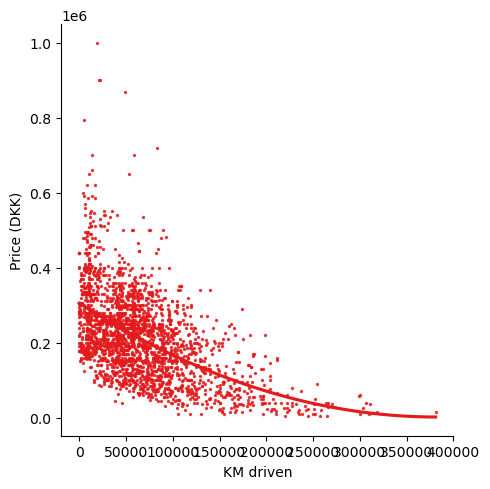

In [12]:
sns.lmplot(x="KM driven", y="Price (DKK)", data=final_data,
           order=2, ci=None, scatter_kws={"s": 2});

<Axes: xlabel='Price (DKK)', ylabel='KM driven'>

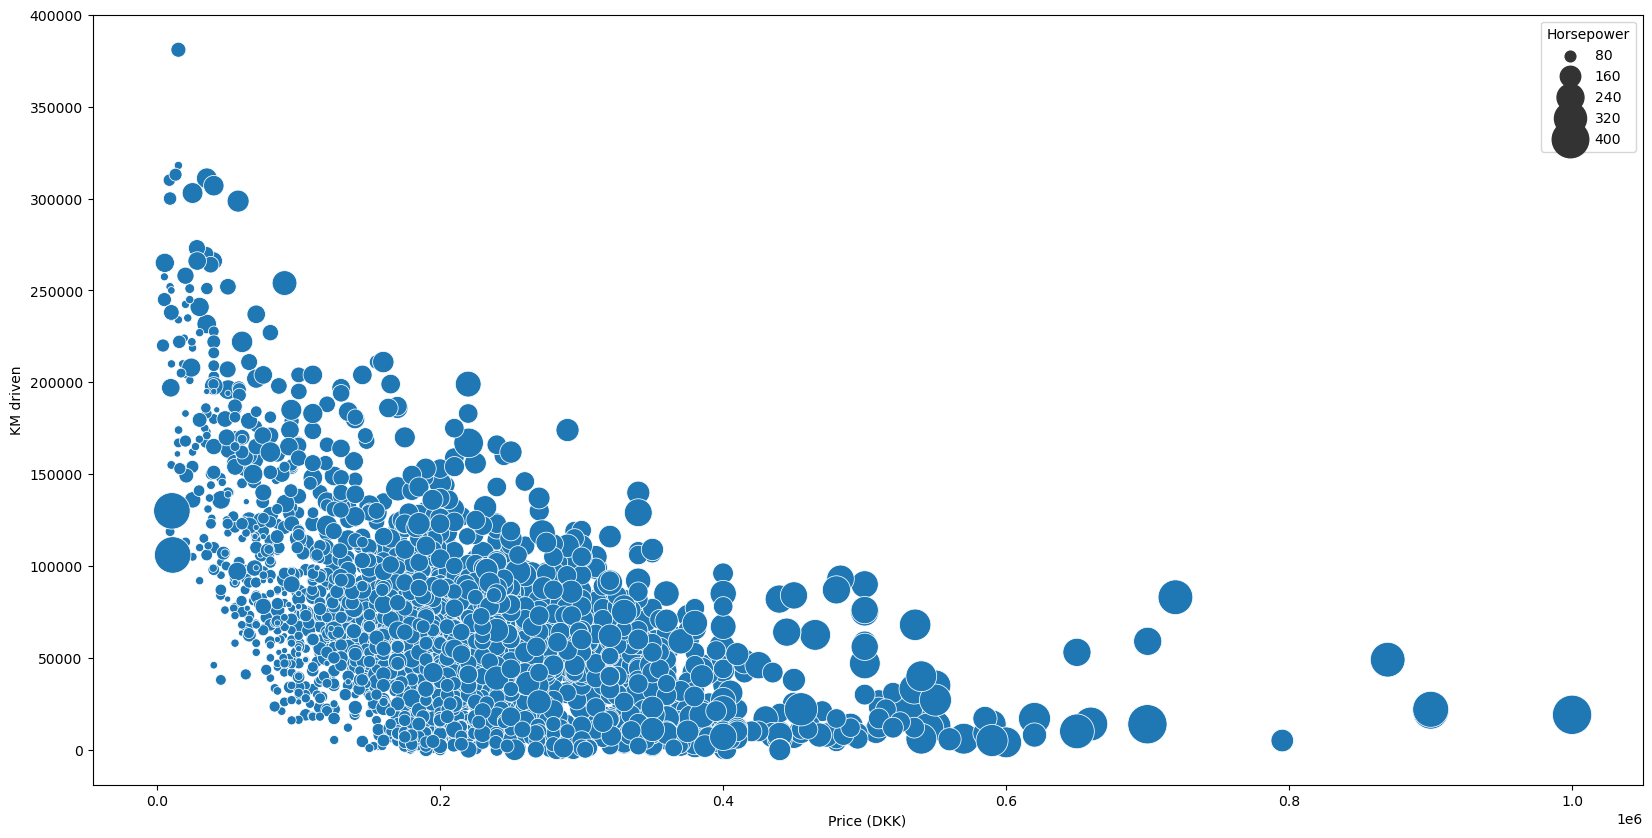

In [9]:
sns.scatterplot(
    data=final_data, x="Price (DKK)", y="KM driven", size="Horsepower",
    sizes=(20, 800)
)



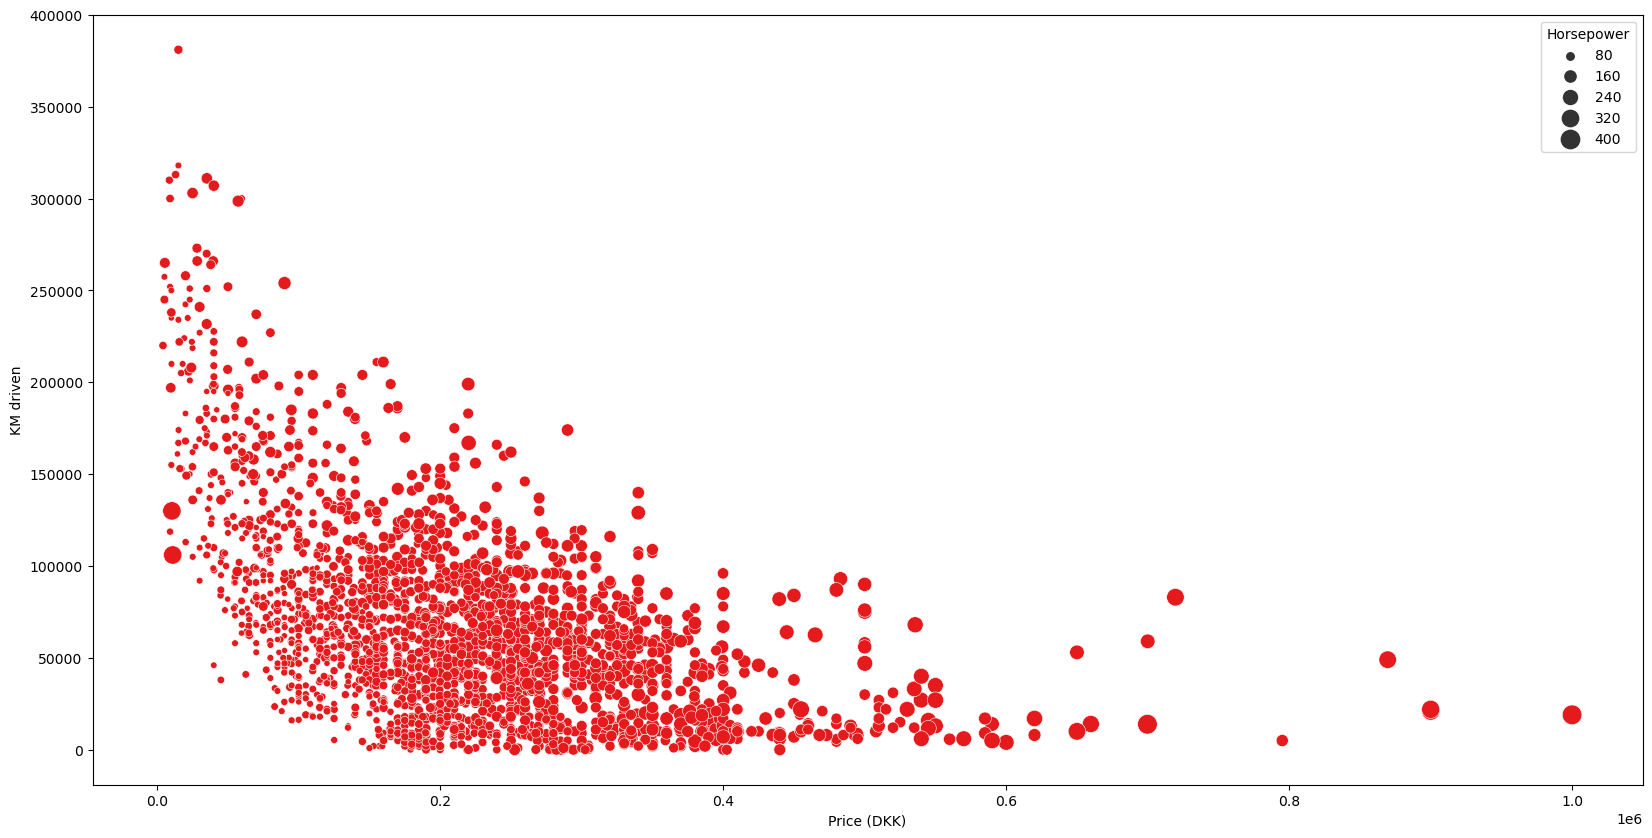

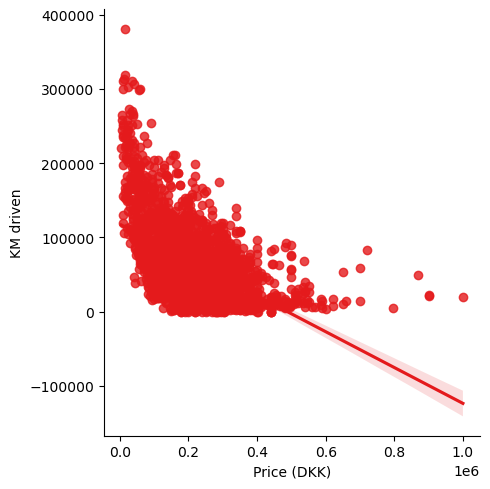

In [10]:
sns.set_palette("Set1")

# Create the scatter plot
scatter_plot = sns.scatterplot(
    data=final_data, x="Price (DKK)", y="KM driven",
    size="Horsepower",
    sizes=(20, 200)
)
sns.lmplot(data=final_data, x="Price (DKK)", y="KM driven")


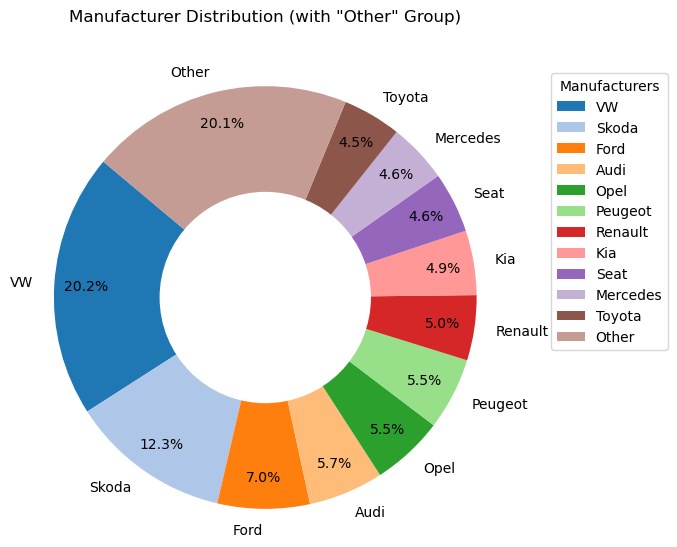

In [31]:
colors = sns.color_palette('pastel')

#create pie chart
manufacturer_counts = final_data['Car Manufacturer'].value_counts()

threshold = 100

# Find groups with counts below the threshold
small_groups = manufacturer_counts[manufacturer_counts < threshold]

# Replace small groups with 'Other'
manufacturer_counts['Other'] = small_groups.sum()
manufacturer_counts.drop(small_groups.index, inplace=True)

colors = plt.cm.tab20.colors

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(manufacturer_counts, labels=manufacturer_counts.index, autopct='%1.1f%%', startangle=140,
        colors=colors, shadow=False, pctdistance=0.85)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Manufacturer Distribution (with "Other" Group)',y=1.08)
plt.legend(title='Manufacturers', loc='upper left', bbox_to_anchor=(1.1, 1))
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

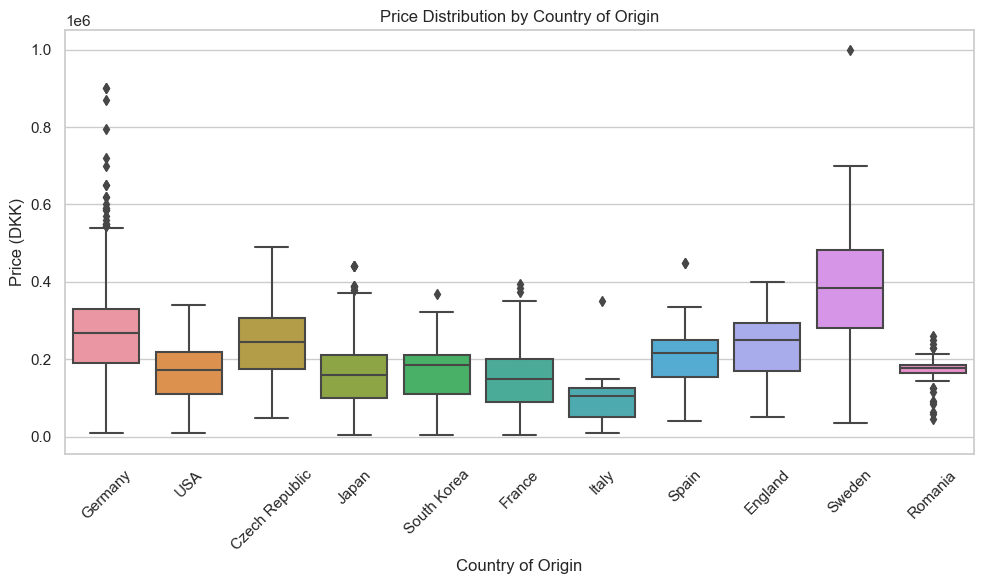

In [53]:
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(10, 6))  # Set the size of the plot

# Create the boxplot using seaborn
sns.boxplot(data=final_data, x='Country of Origin_x', y='Price (DKK)')


plt.title('Price Distribution by Country of Origin')
plt.xlabel('Country of Origin')
plt.ylabel('Price (DKK)')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

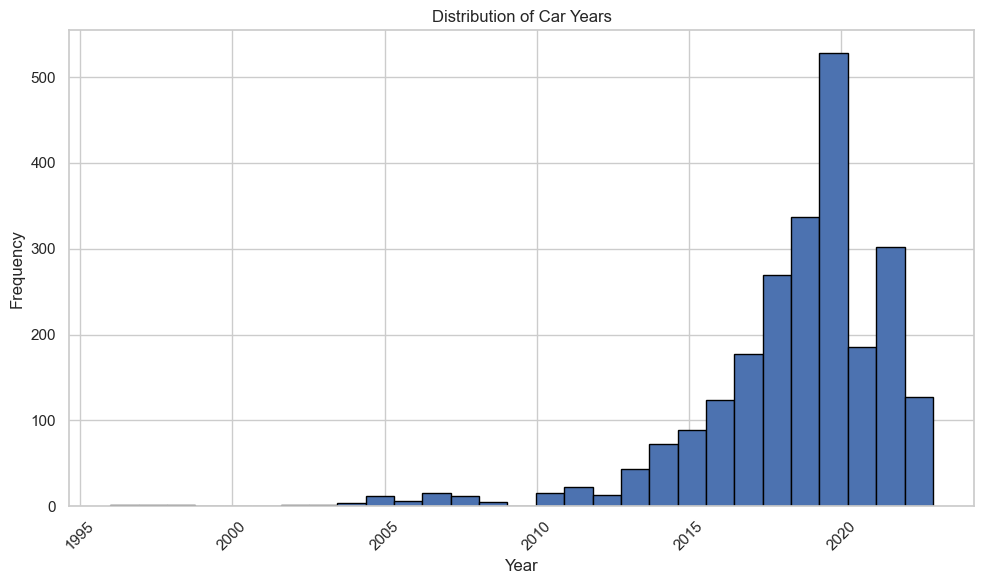

In [58]:
plt.figure(figsize=(10, 6))  # Set the size of the plot

# Create the histogram using matplotlib
plt.hist(final_data['Year'], bins=29, edgecolor='black')

plt.title('Distribution of Car Years')
plt.xlabel('Year')
plt.ylabel('Frequency')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = final_data[['Year', 'KM driven', 'Motor (Litres)', 'Horsepower','Car Manufacturer', 'Transmission']]
y = final_data['Price (DKK)']

X = pd.get_dummies(X, columns=['Car Manufacturer','Transmission'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print(f'ez',r2)

ez 0.7346925825479614


In [70]:
coefficients = model.coef_

# Create a dictionary to map feature names to coefficients
feature_coefficients = dict(zip(X.columns, coefficients))

# Print the coefficients for each feature
for feature, coefficient in feature_coefficients.items():
    print(f'{feature}: {coefficient}')

Year: 5304.05729335496
KM driven: -0.5995840512313517
Motor (Litres): 12784.58180396574
Horsepower: 1623.596144011638
Car Manufacturer_Audi: 29496.688457381053
Car Manufacturer_BMW: 36698.171811965134
Car Manufacturer_Citroën: -48527.196683102135
Car Manufacturer_Fiat: -3337.7132355131894
Car Manufacturer_Ford: -32232.60421229419
Car Manufacturer_Hyundai: -23278.731863128825
Car Manufacturer_Kia: -15579.250671905387
Car Manufacturer_Mazda: -14694.275896485702
Car Manufacturer_Mercedes: 118517.15141083657
Car Manufacturer_Nissan: -23949.79775323134
Car Manufacturer_Opel: -10318.19068264361
Car Manufacturer_Peugeot: 3520.5446606756686
Car Manufacturer_Renault: 2093.0152081535894
Car Manufacturer_Seat: -14617.130350865458
Car Manufacturer_Skoda: 13054.068475586208
Car Manufacturer_Suzuki: -46227.99634695326
Car Manufacturer_Toyota: -7023.187838901536
Car Manufacturer_VW: 36406.4355104265
Transmission_Automatgear: 426.5040755638751
Transmission_Manuelt gear: -426.5040755639521


In [71]:
from sklearn.linear_model import Lasso
# Create and fit the Lasso model
lasso_model = Lasso(alpha=1)  # You can adjust the alpha value
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred1 = lasso_model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared (Lasso):', r2)

R-squared (Lasso): 0.7346925825479614


/Users/christianbakolesen/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e+10, tolerance: 2.252e+08
  model = cd_fast.enet_coordinate_descent(


In [72]:
# Get the learned coefficients
lasso_coefficients = lasso_model.coef_

# Create a dictionary to map feature names to coefficients
feature_coefficients = dict(zip(X.columns, lasso_coefficients))

# Print the coefficients for each feature
for feature, coefficient in feature_coefficients.items():
    print(f'{feature}: {coefficient}')

Year: 5300.773537228194
KM driven: -0.5995279230432071
Motor (Litres): 12690.71091636845
Horsepower: 1624.5101492240392
Car Manufacturer_Audi: 28041.04689703832
Car Manufacturer_BMW: 35216.63451076042
Car Manufacturer_Citroën: -49726.25949963576
Car Manufacturer_Fiat: -4560.994284451606
Car Manufacturer_Ford: -33634.69811736601
Car Manufacturer_Hyundai: -24517.009561152576
Car Manufacturer_Kia: -16947.69296481004
Car Manufacturer_Mazda: -16043.936829646724
Car Manufacturer_Mercedes: 117041.80321780441
Car Manufacturer_Nissan: -25278.363740943187
Car Manufacturer_Opel: -11705.7262790023
Car Manufacturer_Peugeot: 2064.283098836229
Car Manufacturer_Renault: 589.0039261320081
Car Manufacturer_Seat: -16043.035081951819
Car Manufacturer_Skoda: 11608.06129509089
Car Manufacturer_Suzuki: -47439.62612996631
Car Manufacturer_Toyota: -8379.488616756247
Car Manufacturer_VW: 34972.134088450475
Transmission_Automatgear: 880.7549308605131
Transmission_Manuelt gear: -0.0


In [73]:
from sklearn.linear_model import ElasticNet
elasticnet_model = ElasticNet(alpha=1, l1_ratio=.5)  # You can adjust the alpha and l1_ratio values
elasticnet_model.fit(X_train, y_train)

# Make predictions
y_pred = elasticnet_model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared (ElasticNet):', r2)

R-squared (ElasticNet): 0.6758812126433023


In [74]:
elasticnet_coefficients = elasticnet_model.coef_

# Create a dictionary to map feature names to coefficients
feature_coefficients = dict(zip(X.columns, elasticnet_coefficients))

# Print the coefficients for each feature
for feature, coefficient in feature_coefficients.items():
    print(f'{feature}: {coefficient}')

Year: 4877.155625462377
KM driven: -0.6151410163774096
Motor (Litres): -1411.9694664560877
Horsepower: 2112.5796623143797
Car Manufacturer_Audi: 598.1385693008735
Car Manufacturer_BMW: 620.5152934418226
Car Manufacturer_Citroën: -424.5859975427651
Car Manufacturer_Fiat: 15.641701054468946
Car Manufacturer_Ford: -2442.151160091021
Car Manufacturer_Hyundai: -284.98532587004564
Car Manufacturer_Kia: -1000.0521524653848
Car Manufacturer_Mazda: -1553.7745718398646
Car Manufacturer_Mercedes: 10681.30124454836
Car Manufacturer_Nissan: -708.2555918796729
Car Manufacturer_Opel: -1200.63747347853
Car Manufacturer_Peugeot: -365.87957379705557
Car Manufacturer_Renault: -264.59970742825504
Car Manufacturer_Seat: -6792.906548309011
Car Manufacturer_Skoda: -2446.2950212165233
Car Manufacturer_Suzuki: -655.6475740706077
Car Manufacturer_Toyota: -232.02261601877404
Car Manufacturer_VW: 6464.19647240411
Transmission_Automatgear: 971.8192544320347
Transmission_Manuelt gear: -971.819230953082


In [75]:
from sklearn.model_selection import cross_val_score

# Load and prepare your data
# X and y are your feature matrix and target variable

# Perform cross-validation with 5 folds
cross_val_score1 = cross_val_score(model, X, y, cv=5, scoring='r2')
cross_val_score2 = cross_val_score(lasso_model, X, y, cv=5, scoring='r2')
cross_val_score3 = cross_val_score(elasticnet_model, X, y, cv=5, scoring='r2')

cross_val_scores = [cross_val_score1, cross_val_score2, cross_val_score3]
# Print the R-squared scores for each fold
for i, cross_val_score in enumerate(cross_val_scores):
    print("Cross-Validation R-squared scores:", cross_val_scores)
for i in range(3):
    print("Average R-squared:", cross_val_score[i].mean())

Cross-Validation R-squared scores: [array([0.42057529, 0.63781051, 0.67906373, 0.89058   , 0.71836196]), array([0.45073039, 0.63789802, 0.67734098, 0.87888357, 0.65668537]), array([0.59242334, 0.5235699 , 0.51569605, 0.8885456 , 0.48307429])]
Cross-Validation R-squared scores: [array([0.42057529, 0.63781051, 0.67906373, 0.89058   , 0.71836196]), array([0.45073039, 0.63789802, 0.67734098, 0.87888357, 0.65668537]), array([0.59242334, 0.5235699 , 0.51569605, 0.8885456 , 0.48307429])]
Cross-Validation R-squared scores: [array([0.42057529, 0.63781051, 0.67906373, 0.89058   , 0.71836196]), array([0.45073039, 0.63789802, 0.67734098, 0.87888357, 0.65668537]), array([0.59242334, 0.5235699 , 0.51569605, 0.8885456 , 0.48307429])]
Average R-squared: 0.5924233376539096
Average R-squared: 0.5235698992689026
Average R-squared: 0.5156960520918835


/Users/christianbakolesen/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.196e+09, tolerance: 9.958e+07
  model = cd_fast.enet_coordinate_descent(
/Users/christianbakolesen/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e+10, tolerance: 2.154e+08
  model = cd_fast.enet_coordinate_descent(
/Users/christianbakolesen/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co